# Base Station using Wave Propagation Simulaton.

## Initialize Libraries

In [3]:
from wcscore import WCsimEnvCore
import matplotlib.pyplot as plt # plot
from mpl_toolkits import mplot3d # 3D plot
import numpy as np
np.random.seed(0) # initialize random seed

## Environment Setup

In [40]:
env = WCsimEnvCore(server_ip='127.0.0.1', server_port=8877)

Server: Hello Client 
Connected to Server successfully.
The Simulator is ready.


## Generate Base Station and Users

In [41]:
def GenerateScene(n_users= 100):
    # Reset the environment
    env.reset()
    user_positions = []
    # Add a station
    env.add_station([0, 7, 0], [0,0,0], 3.5e9) # location, rotation, frequency.
    stations = env.ask_stations_info()
    station_id = stations[-1] 
    # Add Users
    for i in range(n_users):
        while True:
            random_position = list(np.multiply(np.random.rand(3), [200, 1, 200]) + [-100, 1, -100])
            env.add_user(random_position)
            user_id = env.ask_users_info()[-1]
            env.connect_user_to_station(station_id, user_id)
            user_info = env.ask_user_info(user_id)
            # Remove the user if generated inside the building.
            if user_info['path loss'] != None:
                x,y,z = random_position
                user_positions.append({'x':x, 'y':y, 'z':z})
                break
            env.disconnect_user_from_station(station_id, user_id)
            env.remove_user(user_id)
    return user_positions, station_id

In [42]:
def DisplayUsers(user_positions):
    x_list,y_list, z_list = [],[],[]
    for pos in user_positions:
        x_list.append(pos['x'])
        y_list.append(pos['y'])
        z_list.append(pos['z'])

    ax = plt.axes(projection='3d')
    ax.scatter(x_list, z_list, y_list)
    ax.set_zlabel('Y [m]')
    ax.view_init(40, 60)
    plt.xlabel('X [m]')
    plt.ylabel('Z [m]')
    plt.title('User Positions')
    plt.show()

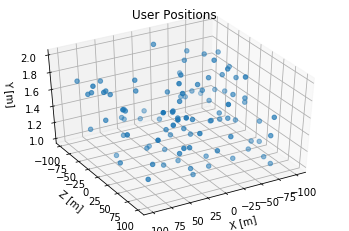

In [43]:
# Generate Users and A station
user_positions, station_id = GenerateScene(n_user=100)
# Display Users' Distribution
DisplayUsers(user_positions)

## Gradient Ascent Model for Location Optimization

### The Base Station Evaluation
The base station evaluates the quality by averaging the total path loss of connected users.
\begin{equation}
    PL_{avg}(\varepsilon, x_{tx} , y_{tx}, z_{tx}) = \frac{1}{N_r} \sum_{i=1}^{N_r}PL_{i}(\varepsilon, x_{rx_{i}}, y_{rx_{i}}, z_{rx_{i}}, x_{tx}, y_{tx}, z_{tx})
\end{equation}
where,
\begin{equation}
\varepsilon  - \text{an environment.} \\
x_{tx} - \text{transmitter location on x-axis.} \\
y_{tx} - \text{transmitter location on y-axis.}\\
z_{tx} - \text{transmitter location on z-axis.}\\
N_r - \text{number of connected receivers.}
\end{equation}

### The Gradient of Base Station Location
The gradient of the current location can be measured by observing the change of average path loss in small different positions.

\begin{equation}
d x_{tx} =\frac{\partial PL_{avg}}{\partial x_{tx}} = \frac{PL_{avg}(x_{tx} + \epsilon , y_{tx}, z_{tx}, \theta_{tx}, \phi_{tx}) - PL_{avg}(x_{tx} - \epsilon , y_{tx}, z_{tx}, \theta_{tx}, \phi_{tx})}{2\epsilon}
\end{equation}

\begin{equation}
d z_{tx} =\frac{\partial PL_{avg}}{\partial z_{tx}}  = \frac{PL_{avg}(x_{tx}  , y_{tx}, z_{tx} + \epsilon, \theta_{tx}, \phi_{tx}) - PL_{avg}(x_{tx} , y_{tx}, z_{tx} - \epsilon , \theta_{tx}, \phi_{tx})}{2\epsilon}
\end{equation}

### Update the location
Then, the location can be updated by its current slope to the higher value as gradient ascent to the better location with lower loss.

\begin{equation}
x_{tx} := x_{tx} + \alpha * d x_{tx} 
\end{equation}
\begin{equation}
z_{tx} := z_{tx} + \alpha * d z_{tx} 
\end{equation}

In [44]:
def GradientModel( station_id, step_rate=0.001, itrations=10):
    eps=0.001
    grads = []
    cache = []
    for i in range(itr):
        station = env.ask_station_info(station_id)
        position = station['position']
        rotation = station['rotation']
        current_pl = station['average path loss']

        # Initialize Check Positions
        pos_x_plus_ep = list(np.array(position) + [ep, 0, 0])
        pot_x_min_ep = list(np.array(position) - [ep, 0, 0])
        pos_z_plus_ep = list(np.array(position) + [0, 0, ep])
        pot_z_min_ep = list(np.array(position) - [0, 0, ep])

        # f_x_plus
        env.move_station_to(station_id, pos_x_plus_ep, rotation)
        x_plus_ep_pl =  env.ask_station_info(station_id)['average path loss']
        if x_plus_ep_pl == None: # the pos_x_plus_ep is inside the building
            x_plus_ep_pl = -200
        # f_x_min
        env.move_station_to(station_id, pot_x_min_ep, rotation)
        x_min_ep_pl =  env.ask_station_info(station_id)['average path loss']
        if x_min_ep_pl == None: # the pot_x_min_ep is inside the building
            x_min_ep_pl = -200

        # f_x_plus
        env.move_station_to(station_id, pos_z_plus_ep, rotation)
        z_plus_ep_pl =  env.ask_station_info(station_id)['average path loss']
        if z_plus_ep_pl == None:# the pos_z_plus_ep is inside the building
            z_plus_ep_pl = -200
        # f_z_min
        env.move_station_to(station_id, pot_z_min_ep, rotation)
        z_min_ep_pl =  env.ask_station_info(station_id)['average path loss']
        if z_min_ep_pl == None:# the pos_z_plus_ep is inside the building
            z_min_ep_pl = -200

        # Calculate the gradients
        dx = (x_plus_ep_pl - x_min_ep_pl)/(2*ep)
        dz = (z_plus_ep_pl - z_min_ep_pl)/(2*ep)
        grad = {'dx':dx, 'dz': dz}
        #print(grad)
        grads.append(grad)

        # If reaching local maxima
        if (dx == 0.0) and (dz == 0.0):
            break

        # Update position
        position = list(np.array(position) + [dx*step_rate, 0, dz*step_rate])

        # Move the station
        env.move_station_to(station_id, position, rotation)

        # Get new information of the station
        improved_station =  env.ask_station_info(station_id)
        avg_pl = improved_station['average path loss']
        new_x = improved_station['position'][0]
        new_z = improved_station['position'][2]
        cache.append({'x': new_x, 'z': new_z, 'avg_pl':avg_pl })
        if i+1%5 == 0:
            print("itr #%d, pos: (%f,%f), avg_pl:%f"%(i, new_x, new_z, avg_pl))
    return grads, cache

In [45]:
# Run the model
grads, cache = GradientModel(station_id=station_id)

itr #0, pos: (-1.256525,0.000195), avg_pl:-96.531540
itr #5, pos: (-1.232035,3.338130), avg_pl:-96.746849
itr #10, pos: (-1.232300,6.060560), avg_pl:-97.259857


### Display the average path loss during iterations

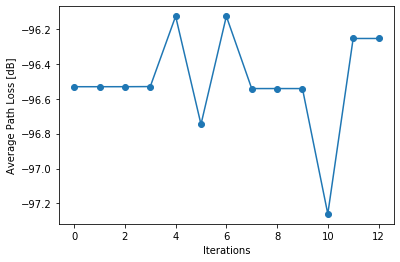

In [46]:
x_list, z_list, avg_pl_list = [], [], []
for data in cache:
    x_list.append(data['x'])
    z_list.append(data['z'])
    avg_pl_list.append(data['avg_pl'])

plt.plot(range(len(avg_pl_list)),avg_pl_list, '-o')
plt.xlabel('Iterations')
plt.ylabel('Average Path Loss [dB]')
plt.show()

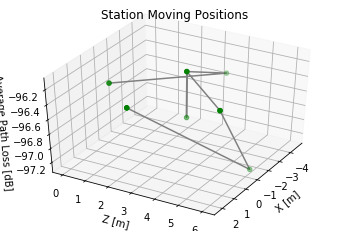

In [47]:
x_list, z_list, avg_pl_list = [], [], []
for data in cache:
    if data['avg_pl'] is None:
        break
    x_list.append(data['x'])
    z_list.append(data['z'])
    avg_pl_list.append(data['avg_pl'])

ax = plt.axes(projection='3d')
ax.plot3D(x_list, z_list, avg_pl_list, 'gray')
ax.scatter(x_list, z_list, avg_pl_list,color = 'g')
ax.set_zlabel('Average Path Loss [dB]')
ax.view_init(20, 20)
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.title('Station Moving Positions')
plt.show()

⚠️ New generated scenario faces gradient explosion and mismatched hyperparameters. 
The model does not work correctly.

## Brute-Force Location Scanning

In this case, we will scan all the positions on the scene at the fixed height of base station.

In [ ]:
user_positions, station_id = GenerateScene(50)
heat_map = []

x_range = range(-100,100,5)
z_range = range(-100,100,5)
# to compute progress %
total_scan = len(x_range)+len(z_range)
count = 0
for x in x_range:
    z_row = []
    for z in z_range:
        position = [x, 7, z]
        env.move_station_to(station_id, position, [0, 0, 0])
        avg_pl = env.ask_station_info(station_id)['average path loss']
        if avg_pl is None:
            avg_pl = -200
        z_row.append(avg_pl)
        count += 1
    print('progress: {0}%'.format(count*100/total_scan));
    heat_map.append(z_row)

In [ ]:
plt.imshow(heat_map, cmap='inferno', interpolation='nearest')
plt.show()

In [ ]:
avg_pl_map = np.array(heat_map)
np.savez_compressed('./assets/npz/new_heat_map.npz', avg_pl_map = avg_pl_map)

## Display the Stored Data

The heatmap has been rendered and stored in a compressed file, we can load the map to visualize the data.

* the data path is "/assets/npz"
* heat_map.npz is the result from 2.4GHz transmission of 50 users uniformly random distributed in the scene.

In [4]:
data = np.load('./assets/npz/heat_map.npz', 'r')
heat_map = data['arr_0']

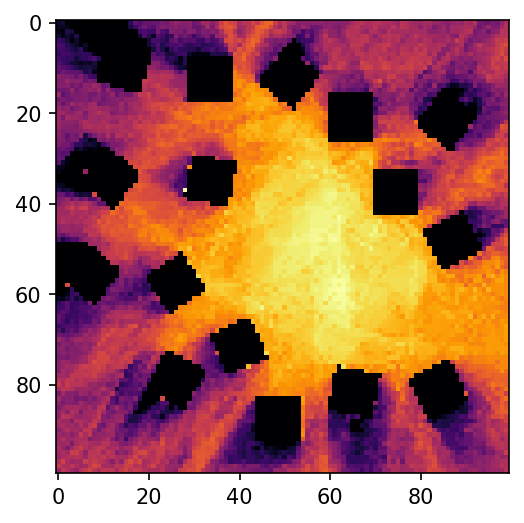

In [14]:
max_l = -140
heat_map[heat_map < max_l] = max_l
heat_map[heat_map > -80.22] = max_l 
plt.imshow(heat_map, cmap='inferno', interpolation='nearest')
plt.show()

### 3D Map Display

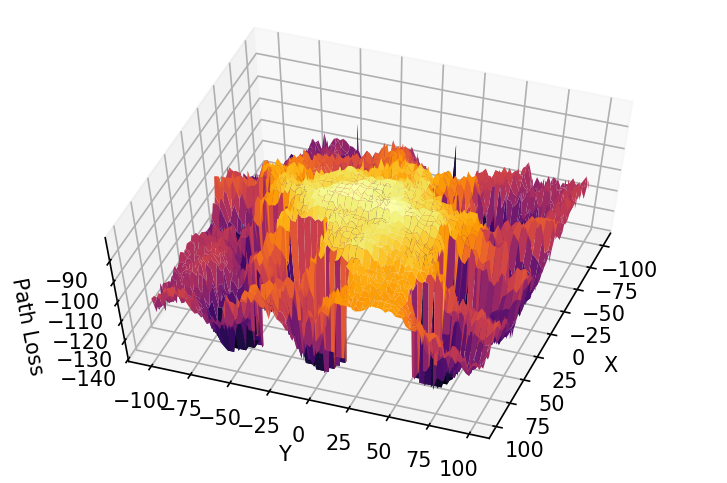

In [13]:
plt.rcParams['figure.dpi'] = 150
ax = plt.axes(projection='3d')
x = range(-100,100,2)
z = range(-100,100,2)
heat_map_cop = np.array(heat_map)
#y = heat_map_cop/np.linalg.norm(heat_map_cop)
y = heat_map_cop.reshape((100,100))
#y = np.abs(y)
X,Z = np.meshgrid(x,z)
#y = np.abs(y)
ax.plot_surface(X, Z, y, cmap='inferno')
ax.set_zlabel('Path Loss')
ax.view_init(60, 20)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [38]:
env.disconnect()